In [1]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim
from sklearn.base import BaseEstimator, TransformerMixin

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
# dataset
from sklearn.datasets import fetch_20newsgroups
# Import Dataset
# loading train dataset
news_group_train = fetch_20newsgroups(subset='train',remove=('headers', 'footers', 'quotes'))
news_group_data_train = news_group_train.data
news_group_target_names_train = news_group_train.target_names
news_group_target_train = news_group_train.target

# Creating a dataframe from the loaded data
news_train = pd.DataFrame({'news': news_group_data_train, 
                        'class': news_group_target_train})

#Loading test data
news_group_test = fetch_20newsgroups(subset='test',remove=('headers', 'footers', 'quotes'))
news_group_data_test = news_group_test.data
news_group_target_names_test = news_group_test.target_names
news_group_target_test = news_group_test.target

# Creating a dataframe from the loaded data
news_test = pd.DataFrame({'news': news_group_data_test, 
                        'class': news_group_target_test})
#Merging both dataset
frames = [news_train,news_test]
df = pd.concat(frames).reset_index(drop=True)

C:\Users\Vatsal\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import f1_score
from sklearn.semi_supervised import LabelPropagation
print("%d documents" % len(df.index))
print("%d categories" % 20)

18846 documents
20 categories


C:\Users\Vatsal\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
class CleanTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        print("Inside cleaning init")
   
    def fit(self,X,y=None):
        print("Inside cleaning pipe fit")
        return self
    
    
    
    def transform(self,X,y=None):
        print("Inside cleaning pipe transform")
        # Convert to list
        data = X.tolist()

        # Remove Emails
        data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

        # Remove new line characters
        data = [re.sub('\s+', ' ', sent) for sent in data]

        # Remove distracting single quotes
        data = [re.sub("\'", "", sent) for sent in data]

        
        def sent_to_words(sentences):
            for sentence in sentences:
                yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

        data_words = list(sent_to_words(data))
#         # Faster way to get a sentence clubbed as a trigram/bigram
#         # Build the bigram and trigram models
#         bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
#         trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
#         bigram_mod = gensim.models.phrases.Phraser(bigram)
#         trigram_mod = gensim.models.phrases.Phraser(trigram)
#         def make_bigrams(texts):
#             return [bigram_mod[doc] for doc in texts]

#         def make_trigrams(texts):
#             return [trigram_mod[bigram_mod[doc]] for doc in texts]
#         # Form Bigrams
#         data_words_bigrams = make_bigrams(data_words)
        def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
            """https://spacy.io/api/annotation"""
            texts_out = []
            for sent in texts:
                doc = nlp(" ".join(sent)) 
                texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
            return texts_out

        # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
        nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

        # Do lemmatization keeping only Noun, Adj, Verb, Adverb
        data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
        
        #print(data_lemmatized[:1])
        return(data_lemmatized)

C:\Users\Vatsal\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:17: DeprecationWarning: invalid escape sequence \S
<>:20: DeprecationWarning: invalid escape sequence \s
<>:17: DeprecationWarning: invalid escape sequence \S
<>:20: DeprecationWarning: invalid escape sequence \s
<ipython-input-3-7cec5fc52a8f>:17: DeprecationWarning: invalid escape sequence \S
  data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
<ipython-input-3-7cec5fc52a8f>:20: DeprecationWarning: invalid escape sequence \s
  data = [re.sub('\s+', ' ', sent) for sent in data]


In [4]:
class LDATransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        print("Inside lda pipe init")
   
    def fit(self,X,y=None):
        print("Inside lda pipe fit")
        # Create Dictionary
        self.dictionary_LDA = corpora.Dictionary(X)
#         # assume the word 'b' is to be deleted, put its id in a variable
#         del_ids = [k for k,v in self.dictionary_LDA.items() if len(k)<4]

#         # remove unwanted word ids from the dictionary in place
#         self.dictionary_LDA.filter_tokens(bad_ids=del_ids)

        # Term Document Frequency
        corpus = [self.dictionary_LDA.doc2bow(data_lemmatized) for data_lemmatized in X]
        def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
            coherence_values = []
            model_list = []
            for num_topics in range(start, limit, step):
                model = gensim.models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
                model_list.append(model)
                coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
                coherence_values.append(coherencemodel.get_coherence())
            return model_list, coherence_values
        model_list, coherence_values = compute_coherence_values(dictionary=self.dictionary_LDA, corpus=corpus, texts=X, start=2, limit=40, step=6)
        # Show graph
        limit=40; start=2; step=6;
        x = range(start, limit, step)
        plt.plot(x, coherence_values)
        plt.xlabel("Num Topics")
        plt.ylabel("Coherence score")
        plt.legend(("coherence_values"), loc='best')
        plt.show()
        nooftopics=0
        cvscore=0
        # Print the coherence scores
        for m, cv in zip(x, coherence_values):
            if cvscore<cv:
                nooftopics=m
                cvscore=cv
            print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
        print("Best no of Topics =", nooftopics, " has Coherence Value of", round(cvscore, 4))
        # Build LDA model
        self.num_topics =nooftopics
        self.lda_model = gensim.models.LdaModel(corpus, num_topics=self.num_topics, id2word=self.dictionary_LDA, passes=4, alpha=[0.01]*self.num_topics, \
                                           eta=[0.01]*len(self.dictionary_LDA.keys()))
        # Visualize the topics
        pyLDAvis.enable_notebook()
        vis = pyLDAvis.gensim_models.prepare(self.lda_model, corpus, self.dictionary_LDA)
        vis
        return self
        
    def transform(self,X):
        print("Inside lda pipe transform")
            
        # Term Document Frequency
        corpus = [self.dictionary_LDA.doc2bow(data_lemmatized) for data_lemmatized in X]
        
        topics = [self.lda_model[corpus[i]] for i in range(len(X))]
        def topics_document_to_dataframe(topics_document, num_topics):
            res = pd.DataFrame(columns=range(num_topics))
            for topic_weight in topics_document:
                res.loc[0, topic_weight[0]] = topic_weight[1]
            return res
        features=pd.concat([topics_document_to_dataframe(topics_document, num_topics=self.num_topics) for topics_document in topics]) \
            .reset_index(drop=True).fillna(0)
        #print(features)
        return features.to_numpy()
            
       


C:\Users\Vatsal\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
from sklearn.preprocessing import FunctionTransformer
# Parameters
sdg_params = dict(alpha=1e-5, penalty='l2', loss='log')

# Supervised Pipeline
pipeline = Pipeline([
    ('CleanTransformer', CleanTransformer()),
    ('LDATransformer', LDATransformer()),
    ('clf', SGDClassifier(**sdg_params)),
])
# SelfTraining Pipeline
st_pipeline = Pipeline([
    ('CleanTransformer', CleanTransformer()),
    ('LDATransformer', LDATransformer()),
    ('clf', SelfTrainingClassifier(SGDClassifier(**sdg_params), verbose=True)),
])
# LabelSpreading Pipeline
lp_pipeline = Pipeline([
    ('CleanTransformer', CleanTransformer()),
    ('LDATransformer', LDATransformer()),
    # LabelSpreading does not support dense matrices
    #('todense', FunctionTransformer(lambda x: x.todense())),
    ('clf', LabelPropagation(max_iter=2000)),
])

Inside cleaning init
Inside lda pipe init
Inside cleaning init
Inside lda pipe init
Inside cleaning init
Inside lda pipe init


C:\Users\Vatsal\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\Vatsal\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Supervised SGDClassifier on 100% of the data:
Number of training samples: 12626
Unlabeled samples in training set: 0
Inside cleaning pipe fit
Inside cleaning pipe transform
Inside lda pipe fit


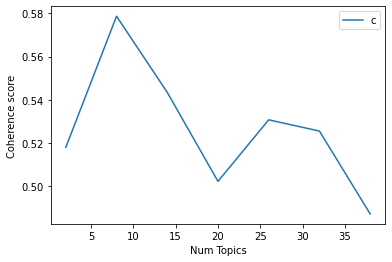

Num Topics = 2  has Coherence Value of 0.518
Num Topics = 8  has Coherence Value of 0.5787
Num Topics = 14  has Coherence Value of 0.5435
Num Topics = 20  has Coherence Value of 0.5023
Num Topics = 26  has Coherence Value of 0.5307
Num Topics = 32  has Coherence Value of 0.5256
Num Topics = 38  has Coherence Value of 0.4872
Best no of Topics = 8  has Coherence Value of 0.5787
Inside lda pipe transform
Inside cleaning pipe transform
Inside lda pipe transform
Micro-averaged F1 score on test set: 0.260
----------

Supervised SGDClassifier on 20% of the training data:
Number of training samples: 2584
Unlabeled samples in training set: 0
Inside cleaning pipe fit
Inside cleaning pipe transform
Inside lda pipe fit


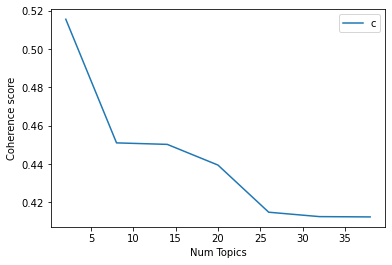

Num Topics = 2  has Coherence Value of 0.5155
Num Topics = 8  has Coherence Value of 0.4509
Num Topics = 14  has Coherence Value of 0.4502
Num Topics = 20  has Coherence Value of 0.4394
Num Topics = 26  has Coherence Value of 0.4148
Num Topics = 32  has Coherence Value of 0.4125
Num Topics = 38  has Coherence Value of 0.4123
Best no of Topics = 2  has Coherence Value of 0.5155
Inside lda pipe transform
Inside cleaning pipe transform
Inside lda pipe transform
Micro-averaged F1 score on test set: 0.095
----------

SelfTrainingClassifier on 20% of the training data (rest is unlabeled):
Number of training samples: 12626
Unlabeled samples in training set: 10042
Inside cleaning pipe fit
Inside cleaning pipe transform
Inside lda pipe fit


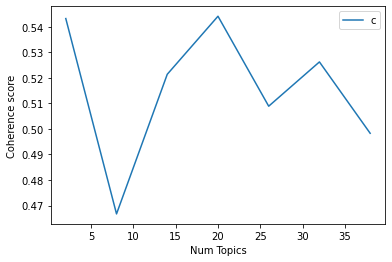

Num Topics = 2  has Coherence Value of 0.5432
Num Topics = 8  has Coherence Value of 0.4667
Num Topics = 14  has Coherence Value of 0.5214
Num Topics = 20  has Coherence Value of 0.5441
Num Topics = 26  has Coherence Value of 0.5089
Num Topics = 32  has Coherence Value of 0.5262
Num Topics = 38  has Coherence Value of 0.4983
Best no of Topics = 20  has Coherence Value of 0.5441
Inside lda pipe transform
End of iteration 1, added 845 new labels.
End of iteration 2, added 205 new labels.
End of iteration 3, added 258 new labels.
End of iteration 4, added 319 new labels.
End of iteration 5, added 28 new labels.
End of iteration 6, added 46 new labels.
End of iteration 7, added 20 new labels.
End of iteration 8, added 107 new labels.
End of iteration 9, added 35 new labels.
End of iteration 10, added 9 new labels.
Inside cleaning pipe transform
Inside lda pipe transform
Micro-averaged F1 score on test set: 0.374
----------

LabelSpreading on 20% of the data (rest is unlabeled):
Number of t

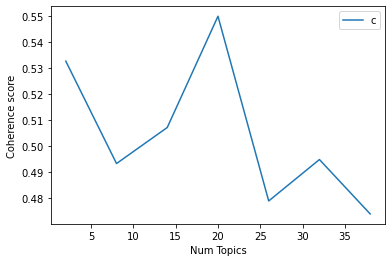

Num Topics = 2  has Coherence Value of 0.5327
Num Topics = 8  has Coherence Value of 0.4933
Num Topics = 14  has Coherence Value of 0.5071
Num Topics = 20  has Coherence Value of 0.55
Num Topics = 26  has Coherence Value of 0.4788
Num Topics = 32  has Coherence Value of 0.4948
Num Topics = 38  has Coherence Value of 0.4738
Best no of Topics = 20  has Coherence Value of 0.55
Inside lda pipe transform
Inside cleaning pipe transform
Inside lda pipe transform
Micro-averaged F1 score on test set: 0.350
----------



In [6]:
import os
def eval_and_print_metrics(clf, X_train, y_train, X_test, y_test):
    print("Number of training samples:", len(X_train))
    print("Unlabeled samples in training set:",
          sum(1 for x in y_train if x == -1))
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("Micro-averaged F1 score on test set: "
          "%0.3f" % f1_score(y_test, y_pred, average='micro'))
    print("-" * 10)
    print()


if __name__ == "__main__":
    X, y = df['news'],df['class']
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33,random_state=0,stratify=y)

    print("Supervised SGDClassifier on 100% of the data:")
    eval_and_print_metrics(pipeline, X_train, y_train, X_test, y_test)

    # select a mask of 20% of the train dataset
    y_mask = np.random.rand(len(y_train)) < 0.2

    # X_20 and y_20 are the subset of the train dataset indicated by the mask
    X_20, y_20 = map(list, zip(*((x, y)
                     for x, y, m in zip(X_train, y_train, y_mask) if m)))
    
    print("Supervised SGDClassifier on 20% of the training data:")
    eval_and_print_metrics(pipeline, np.array(X_20), np.array(y_20), X_test, y_test)

    # set the non-masked subset to be unlabeled
    y_train[~y_mask] = -1
    print("SelfTrainingClassifier on 20% of the training data (rest "
          "is unlabeled):")
    eval_and_print_metrics(st_pipeline, X_train, y_train, X_test, y_test)

    if 'CI' not in os.environ:
        print("LabelSpreading on 20% of the data (rest is unlabeled):")
        eval_and_print_metrics(lp_pipeline, X_train, y_train, X_test, y_test)